# 微分方程式をディープラーニングで解く

解きたい微分方程式を
$$
u_t+{\mathcal N}[u]=0
$$
と表す。ここで$u(t, x)$は求めるべき解、${\mathcal N}[\bullet]$は空間微分などを含む演算子である。$x\in\Omega$は${\bf R}^d$上の部分空間を、$t\in[0,T]$は時間を表す。下付き文字は偏微分を表す。上式の右辺を
$$
f:=u_t+{\mathcal N}[u]
$$
と定義し、$u$をディープニューラルネットで近似することを考える。損失関数は二乗誤差
$$
MSE=MSE_u+MSE_f
$$
とする。ここで、
\begin{align}
MSE_u&=\frac{1}{N_u}\sum_{i=1}^{N_u}|u(t_u^i,x_u^i)-u^i|^2 \\
MSE_f&=\frac{1}{N_f}\sum_{i=1}^{N_f}|f(t_f^i,t_f^i)|^2
\end{align}
はそれぞれ拘束条件（初期条件や境界条件）に関する誤差、微分方程式そのものに関する誤差である。拘束条件が式で与えられている場合（時間反転対称性など）は、別途該当する二乗誤差の項を追加すればよい。$\{t_u^i,x_u^i,u_i\}_{i=1}^{N_u}$は拘束条件の訓練データ、$\{t _f^i,x _f^i\} _{i=1}^{N _f}$は微分方程式そのものに対する訓練データである。これを最小化することで微分方程式の近似解を得る。

# Burger's equation
Dirichlet境界条件下のBurger's equation
\begin{align}
&u_t+uu_x -(0.01/\pi)u_{xx}=0,\,x\in[-1,1],\,t\in[0,1]\\
&u(0,x)=-\sin(\pi x)\\
&u(t,-1)=u(t,1)=0
\end{align}

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim, nn
from torch.autograd import grad, Variable
from torch.utils import data
import torch.nn.functional as F

In [14]:
LEARNING_RATE = 1e-4

class Net(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_size=20, hidden_layer_size=9):
        super().__init__()
        self.inp = nn.Sequential(
            nn.Linear(input_shape, hidden_size), 
            nn.Tanh()
        )
        fc = [nn.Sequential(nn.Linear(hidden_size, hidden_size) ,
                            nn.Tanh()
                           ) for _ in range(hidden_layer_size)]
        self.fc = nn.ModuleList(fc)
        self.out = nn.Sequential(
            nn.Linear(hidden_size, output_shape),
        )
        
    def forward(self, x):
        f = self.inp(x)
        for i in range(len(self.fc)):
            f = self.fc[i](f)
        return self.out(f)

class burgers_eq:
    def __init__(self, X_u, T_u, U, X_f, T_f, cuda=False):
        self.device = "cuda" if cuda else "cpu"
        self.net = Net(2, 1).to(self.device)
        self.optimizer = optim.RMSprop(self.net.parameters(), lr=LEARNING_RATE)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', patience=1)
        self.data_loader_u = data.DataLoader(data.TensorDataset(X_u, T_u, U), batch_size=50)
        self.data_loader_f = data.DataLoader(data.TensorDataset(X_f, T_f), batch_size=500)
        self.log = []

    def neural_network(self, x, t):
        X = torch.cat((x, t), 1).to(self.device)
        return self.net(X)

    def d_eq(self, x, t, f, i):
        df_dx = grad(f, x, create_graph=True)[0][i]
        df_dt = grad(f, t, create_graph=True)[0][i]
        df_dx2 = grad(df_dx, x, create_graph=True)[0][i]
        return df_dt + f * df_dx - (0.01/np.pi) * df_dx2

    def MSE_f(self, x, t):
        batch_size = len(x)
        x = torch.FloatTensor(x).requires_grad_().unsqueeze(-1).to(self.device)
        t = torch.FloatTensor(t).requires_grad_().unsqueeze(-1).to(self.device)
        f = self.neural_network(x, t).to(self.device)
        mse_f = 0
        for i in range(batch_size):
            mse_f += self.d_eq(x, t, f[i], i).to(self.device) ** 2 / batch_size

        return mse_f

    def MSE_u(self, x, t, u):
        batch_size = len(x)
        x = torch.FloatTensor(x).requires_grad_().unsqueeze(-1).to(self.device)
        t = torch.FloatTensor(t).requires_grad_().unsqueeze(-1).to(self.device)
        u = torch.FloatTensor(u).requires_grad_().unsqueeze(-1).to(self.device)
        f = self.neural_network(x, t).to(self.device)
        return (u - f).pow(2).sum() / batch_size

    def solve(self, N_itr):
        for i in range(N_itr):
            torch.cuda.empty_cache()
            t = time.time()
            for (x_u, t_u, u), (x_f, t_f) in zip(self.data_loader_u, self.data_loader_f):
                self.optimizer.zero_grad()
                MSE = self.MSE_u(x_u, t_u, u) + self.MSE_f(x_f, t_f)
                MSE.backward()
                self.optimizer.step()
                torch.cuda.empty_cache()
            mse_u = self.MSE_u(x_u, t_u, u).item()
            mse_f = self.MSE_f(x_f, t_f).item()
            MSE = mse_u + mse_f
#             self.scheduler.step(MSE, i)
            print("step #{}, loss_u={:.2e}, loss_f={:.2e}, los_tot={:.2e}, time={:.2f}[s]".format(i + 1, mse_u, mse_f, MSE, time.time() - t))
            t = time.time()
            self.log.append((mse_u, mse_f, MSE))
            del mse_u, mse_f, MSE

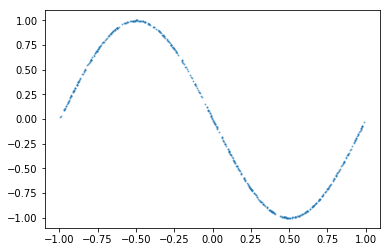

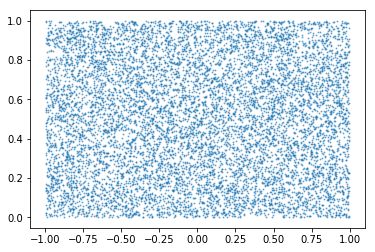

step #1, loss_u=9.35e-03, loss_f=8.57e-08, los_tot=9.35e-03, time=81.87[s]
step #2, loss_u=2.13e-03, loss_f=9.68e-07, los_tot=2.13e-03, time=81.18[s]
step #3, loss_u=6.90e-04, loss_f=4.35e-06, los_tot=6.95e-04, time=82.11[s]
step #4, loss_u=4.86e-04, loss_f=1.39e-05, los_tot=5.00e-04, time=80.69[s]
step #5, loss_u=6.96e-04, loss_f=3.66e-05, los_tot=7.32e-04, time=78.86[s]
step #6, loss_u=1.33e-03, loss_f=8.34e-05, los_tot=1.41e-03, time=79.21[s]
step #7, loss_u=2.67e-03, loss_f=1.69e-04, los_tot=2.84e-03, time=80.08[s]
step #8, loss_u=5.10e-03, loss_f=3.11e-04, los_tot=5.41e-03, time=81.66[s]
step #9, loss_u=8.83e-03, loss_f=5.10e-04, los_tot=9.34e-03, time=80.80[s]
step #10, loss_u=1.37e-02, loss_f=7.45e-04, los_tot=1.44e-02, time=80.27[s]
step #11, loss_u=1.90e-02, loss_f=9.80e-04, los_tot=2.00e-02, time=82.61[s]
step #12, loss_u=2.44e-02, loss_f=1.19e-03, los_tot=2.56e-02, time=81.94[s]
step #13, loss_u=2.94e-02, loss_f=1.35e-03, los_tot=3.07e-02, time=81.00[s]
step #14, loss_u=3.38

In [15]:
N = 1000//2
x_ini = 2 * torch.rand(N) - 1
x_u = torch.cat([x_ini, (2 * torch.randint(2, [N]) - 1).float()])
t_u = torch.cat([torch.zeros(N), torch.rand(N)])
u = torch.cat([-torch.sin(np.pi*x_ini), torch.zeros(N)])

plt.scatter(x_u.numpy()[:N], u.numpy()[:N], s=1, alpha=0.5)
plt.show()

N = 10000
x_f = 2 * torch.rand(N) - 1
t_f = torch.rand(N)

plt.scatter(x_f.numpy(), t_f.numpy(), s=1, alpha=0.5)
plt.show()

solver = burgers_eq(x_u, t_u, u, x_f, t_f, True)
solver.solve(100)

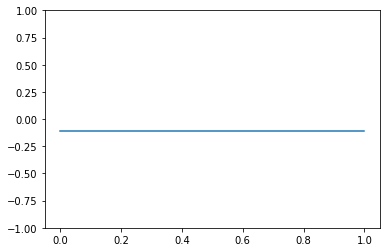

In [141]:
x = np.linspace(0, 1, 100)
t = 10 * np.ones(100)
batch_size = len(x)
x = torch.FloatTensor(x).requires_grad_().unsqueeze(-1)
t = torch.FloatTensor(t).requires_grad_().unsqueeze(-1)
f = solver.neural_network(x, t)
plt.plot(x.squeeze().tolist(), f.squeeze().tolist())
plt.ylim(-1, 1)
plt.show()

# 1次元熱伝導方程式
- インプットは[0, 1]に規格化
- 活性化関数にtanhを使う場合はアウトプットのスケールを[-1,1]に規格化。正の値になるならSigmoidやReLuを使ったほうが良い？

In [ ]:
LEARNING_RATE = 0.001

class heat_transfer_eq:
    def __init__(self, X_u, T_u, U, X_f, T_f, cuda=False):
        self.device = "cuda" if cuda else "cpu"
        self.net = Net(2, 1).to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=LEARNING_RATE, amsgrad=False)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', patience=1)
        self.data_loader_u = data.DataLoader(data.TensorDataset(X_u, T_u, U), batch_size=50)
        self.data_loader_f = data.DataLoader(data.TensorDataset(X_f, T_f), batch_size=500)
        self.log = []

    def neural_network(self, x, t):
        X = torch.cat((x, t), 1).to(self.device)
        return self.net(X)

    def d_eq(self, x, t, f, i):
        df_dx = grad(f, x, create_graph=True)[0][i]
        df_dt = grad(f, t)[0][i]
        df_dx2 = grad(df_dx, x)[0][i]
        k = 0.001
        return df_dt - k * df_dx2

    def MSE_f(self, x, t):
        batch_size = len(x)
        x = torch.FloatTensor(x).requires_grad_().unsqueeze(-1).to(self.device)
        t = torch.FloatTensor(t).requires_grad_().unsqueeze(-1).to(self.device)
        f = self.neural_network(x, t).to(self.device)
        mse_f = 0
        for i in range(batch_size):
            mse_f += self.d_eq(x, t, f[i], i).to(self.device) ** 2 / batch_size

        return mse_f

    def MSE_u(self, x, t, u):
        batch_size = len(x)
        x = torch.FloatTensor(x).requires_grad_().unsqueeze(-1).to(self.device)
        t = torch.FloatTensor(t).requires_grad_().unsqueeze(-1).to(self.device)
        u = torch.FloatTensor(u).requires_grad_().unsqueeze(-1).to(self.device)
        f = self.neural_network(x, t).to(self.device)
        return (u - f).pow(2).sum() / batch_size

    def solve(self, N_itr):
        for i in range(N_itr):
            torch.cuda.empty_cache()
            t = time.time()
            for (x_u, t_u, u), (x_f, t_f) in zip(self.data_loader_u, self.data_loader_f):
                self.optimizer.zero_grad()
                MSE = self.MSE_u(x_u, t_u, u) + self.MSE_f(x_f, t_f)
                MSE.backward()
                self.optimizer.step()
                torch.cuda.empty_cache()
            mse_u = self.MSE_u(x_u, t_u, u).item()
            mse_f = self.MSE_f(x_f, t_f).item()
            MSE = mse_u + mse_f
            self.scheduler.step(MSE, i)
            print("step #{}, loss_u={:.2e}, loss_f={:.2e}, los_tot={:.2e}, time={:.2f}[s]".format(i + 1, mse_u, mse_f, MSE, time.time() - t))
            t = time.time()
            self.log.append((mse_u, mse_f, MSE))
            del mse_u, mse_f, MSE

In [ ]:
N = 1000
x_b = torch.randint(2, [N])
x_u = torch.cat([0.1 + 0.8 * torch.rand(N), x_b])
t_u = torch.cat([torch.zeros(N), 100 * torch.rand(N)])
u = torch.cat([0.25 * torch.ones(N), x_b])

N = 10000
x_f = torch.rand(N)
t_f = 100 * torch.rand(N)

plt.scatter(x_f.numpy(), t_f.numpy(), s=1, alpha=0.5)
plt.show()

solver = heat_transfer_eq(x_u, t_u, u, x_f, t_f, True)
solver.solve(10)

In [ ]:
plt.plot(solver.log)
plt.yscale("log")
plt.show()

In [ ]:
x = np.linspace(0, 1, 100)
t = 10 * np.ones(100)
batch_size = len(x)
x = torch.FloatTensor(x).requires_grad_().unsqueeze(-1)
t = torch.FloatTensor(t).requires_grad_().unsqueeze(-1)
f = solver.neural_network(net, x, t)
plt.plot(x.squeeze().tolist(), f.squeeze().tolist())
plt.show()